# Evaluation of Results 

In [1]:
import numpy as np
import pandas as pd

In [ ]:
import os

import requests
from transformers import BlipProcessor, BlipForQuestionAnswering
from datasets import load_dataset
import torch
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle

model_orig = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor_orig = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_orig.to(device)

torch.cuda.empty_cache()
torch.manual_seed(42)

In [102]:
model = BlipForQuestionAnswering.from_pretrained("ritika-kumar/finetuned-blip-vizwiz")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.cuda.empty_cache()
torch.manual_seed(42)

## Quantitative analysis

In [93]:
import json
train_annotations_path = "/kaggle/input/vizwiz/Annotations/Annotations/train.json" 
val_annotations_path = "/kaggle/input/vizwiz/Annotations/Annotations/val.json"  
image_dir = "train/train"
with open(train_annotations_path, 'r') as f:
    train = json.load(f)
train_df = pd.DataFrame(train)

with open(val_annotations_path, 'r') as f:
    val = json.load(f)

val_df = pd.DataFrame(val)

def get_most_confident_answer(answers):
    if isinstance(answers, list) and len(answers) > 0:
        return max(answers, key=lambda x: x['answer_confidence'])['answer']
    return ""

train_df['most_confident_answer'] = train_df['answers'].apply(get_most_confident_answer)

val_df['most_confident_answer'] = val_df['answers'].apply(get_most_confident_answer)


trian_df = train_df[train_df['answerable'] == 1]	
val_df = val_df[val_df['answerable'] == 1]
train_df = train_df[0:]
val_df = val_df[0:]

In [94]:
def extract_answers(row):
    return [item['answer'] for item in row]
val_df['extracted_answers'] = val_df['answers'].apply(extract_answers)


In [92]:
!pip install -q nltk -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [95]:
!pip install pycocoevalcap -q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [96]:
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.cider.cider import Cider
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm

from nltk.tokenize import word_tokenize
def evaluate_vqa_with_advanced_metrics(processor, model, dataset, device="cuda"):
    """
    Evaluate the VQA model using multiple reference answers and various metrics, including BLEU, METEOR, and CIDEr.

    Args:
        processor: BLIP processor for encoding images and text.
        model: Fine-tuned BLIP model.
        dataset: Validation dataset with "image", "question", and "answers" (list of valid answers).
        device: Device to run the model on ("cuda" or "cpu").

    Returns:
        dict: Evaluation metrics including BLEU, METEOR, CIDEr, accuracy, precision, recall, and F1-score.
    """
    predictions = []
    references_list = []

    model.to(device)
    model.eval()

    smoothing_function = SmoothingFunction().method1

    for i in tqdm(range(len(dataset))):
        image_path ='/kaggle/input/vizwiz/val/val/' + dataset["image"][i]
        image = Image.open(image_path).convert("RGB")
        question = dataset["question"][i]
        references = dataset["extracted_answers"][i]  # List of valid answers

        inputs = processor(images=image, text=question, return_tensors="pt").to(device)
        output = model.generate(**inputs)
        predicted_answer = processor.decode(output[0], skip_special_tokens=True)


        predictions.append(predicted_answer)
        references_list.append(references)

    # Compute BLEU Score
    bleu_scores = [
        sentence_bleu(
            [ref.split() for ref in references], 
            pred.split(),                        
            weights=(0.5, 0.5),
            smoothing_function=smoothing_function
        )
        for references, pred in zip(references_list, predictions)
    ]
    bleu_score = np.mean(bleu_scores)


    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(
        {i: [" ".join(ref) for ref in references] for i, references in enumerate(references_list)},
        {i: [pred] for i, pred in enumerate(predictions)}
    )


    correct = sum(
        1 for refs, pred in zip(references_list, predictions)
        if pred.strip().lower() in [r.strip().lower() for r in refs]
    )
    accuracy = correct / len(references_list)


    y_true = [
        1 if pred.strip().lower() in [r.strip().lower() for r in refs] else 0
        for refs, pred in zip(references_list, predictions)
    ]
    y_pred = [1] * len(y_true)  

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {
        "BLEU": bleu_score,
        "CIDEr": cider_score,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }


In [97]:
val_df = val_df.reset_index()

In [33]:
metrics = evaluate_vqa_with_advanced_metrics(
    processor=processor_orig,
    model=model_orig,
    dataset=val_df,
    device="cuda"
)

print("Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")

100%|██████████| 2934/2934 [06:16<00:00,  7.80it/s]


Evaluation Metrics:
BLEU: 0.17408752190989554
CIDEr: 0.006659796217298932
Accuracy: 0.38139059304703476
Precision: 0.38139059304703476
Recall: 1.0
F1-Score: 0.5521835677276092


In [98]:
metrics = evaluate_vqa_with_advanced_metrics(
    processor=processor,
    model=model,
    dataset=val_df,
    device="cuda"
)

print("Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")

  0%|          | 0/2934 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 2934/2934 [08:03<00:00,  6.06it/s]


Evaluation Metrics:
BLEU: 0.15707037691697637
CIDEr: 0.001604546848212893
Accuracy: 0.4154737559645535
Precision: 0.4154737559645535
Recall: 1.0
F1-Score: 0.5870455092704069


## Qualitative analysis

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_vqa_result(processor, model, dataset, index, prefix):
    """
    Visualizes the VQA results by displaying the image, question, actual answer, and predicted answer.

    Args:
        processor: BLIP processor for encoding images and text.
        model: Fine-tuned BLIP model.
        dataset: Dataset containing "image", "question", and "answer".
        index: index of the sample to visualize.
        prefix: for path

    Returns:
        None
    """
    # Extract data for the given index
    image_path = prefix + dataset["image"][index]
    question = dataset["question"][index]
    actual_answer = dataset["most_confident_answer"][index]

    # Load and display the image
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.axis("off")
    plt.title("Test Image")
    plt.show()

    # Generate prediction
    inputs = processor(images=image, text=question, return_tensors="pt").to("cuda")
    output = model.generate(**inputs)
    predicted_answer = processor.decode(output[0], skip_special_tokens=True)

    # Print question, actual answer, and predicted answer
    print(f"Question: {question}")
    print(f"Actual Answer: {actual_answer}")
    print(f"Predicted Answer: {predicted_answer}")


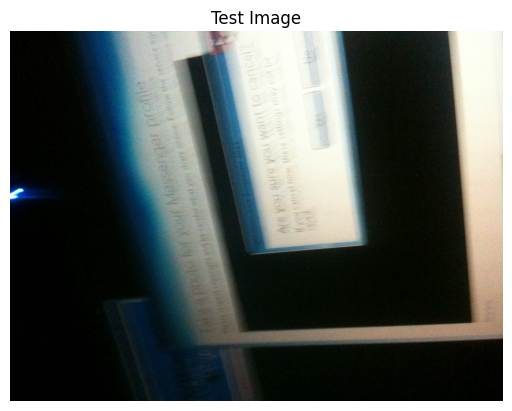

Question: Can you see what's on the screen?
Actual Answer: you sure you want to cancel
Predicted Answer: no


In [69]:
visualize_vqa_result(processor, model, val_df, index=95, prefix = '/kaggle/input/vizwiz/val/val/')

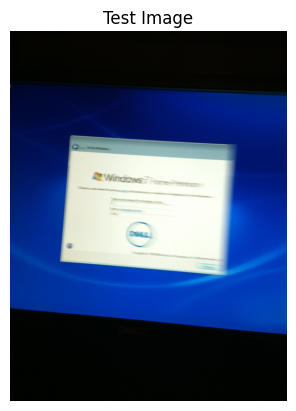

Question: What the screen says? Thank you.
Actual Answer: unsuitable image
Predicted Answer: unsuitable image


In [11]:
visualize_vqa_result(processor, model, val_df, index=5, prefix = '/kaggle/input/vizwiz/val/val/')

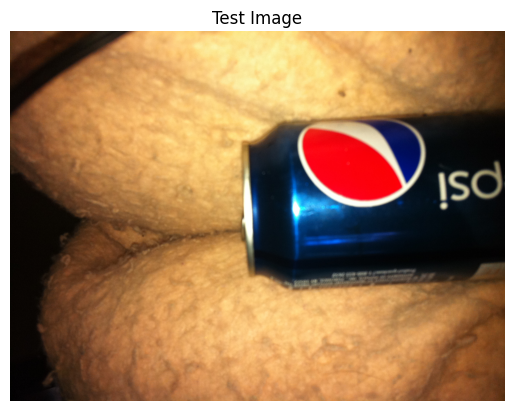

Question: Is this caffeinated or decaffeinated?
Actual Answer: caffeinated
Predicted Answer: pepsi


In [47]:
visualize_vqa_result(processor, model, val_df, index=96, prefix = '/kaggle/input/vizwiz/val/val/')

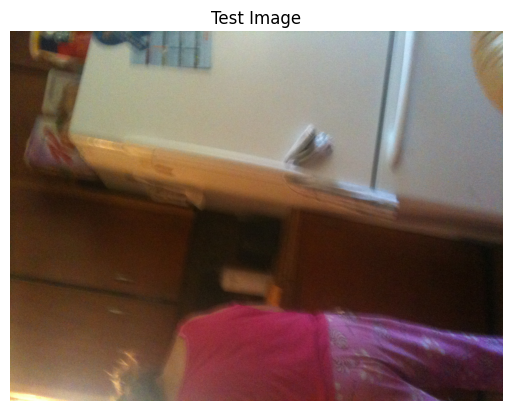

Question: Is this a woman?>
Actual Answer: yes
Predicted Answer: yes


In [73]:
visualize_vqa_result(processor, model, val_df, index=28, prefix = '/kaggle/input/vizwiz/val/val/')

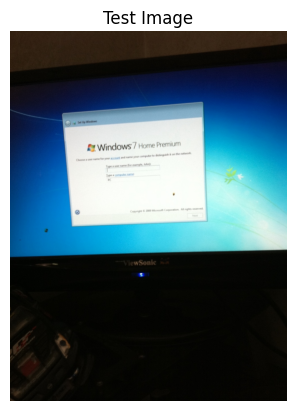

Question: What does the screen say?
Actual Answer: windows 7 home premium
Predicted Answer: windows


In [82]:
visualize_vqa_result(processor, model, val_df, index=127, prefix = '/kaggle/input/vizwiz/val/val/')

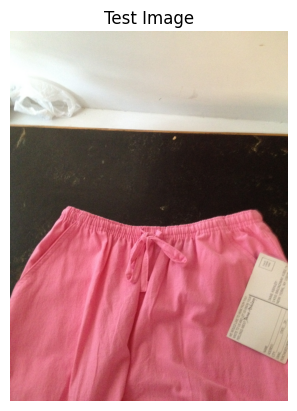

Question: What color are these pants?
Actual Answer: pink
Predicted Answer: pink


In [86]:
visualize_vqa_result(processor, model, val_df, index=3059, prefix = '/kaggle/input/vizwiz/val/val/')